# Plot Source Time in Tract

 work with Weakly_2023_44
- use jupyter kernel LSST
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/12/29
- update : 2023/12/29


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle

plt.rcParams["figure.figsize"] = (16,10)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
# A repo which exists at the USDF, contains data from various instruments and
REPO = '/repo/embargo'

from lsst.daf.butler import Butler
from pprint import pprint

# Here we specify a default collection to use
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"
butler = Butler(REPO, collections=my_collection)
registry = butler.registry

In [3]:
#import lsst.sphgeom
from  lsst.geom import SpherePoint, Angle

In [4]:
Angle(3.1415).asDegrees()

179.9946913403481

In [5]:
Angle(3.1415).asRadians()

3.1415

In [6]:
SpherePoint(Angle(3.1415),Angle(1.0))

SpherePoint(179.9946913403481*degrees, 57.29577951308232*degrees)

In [7]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import coordinates

In [8]:
import pandas as pd

In [9]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

## Config

### Galactic Plane

In [10]:
gal_long = np.linspace(-180.,180,360)
gal_lat = np.zeros((360))

coordinates_galactic_planes = SkyCoord(l=gal_long*u.degree, b=gal_lat*u.degree, frame='galactic')
gp_radec = coordinates_galactic_planes.transform_to('icrs')  

gp_ra_toplot = coordinates.Angle(gp_radec.ra.degree*u.degree)
gp_ra_toplot = gp_ra_toplot.wrap_at(180*u.degree)

### Sources

In [11]:
file = "sourceTable_202312.csv"

In [12]:
suptitle = "Sources, Auxtel phot 2023"

## Skymap, Tracts and Patchs

In [13]:
Auxtel2023_tracts = [ 5616,5634,5615,10644,383,8188,3863,455,452,5839,10643,382]

In [14]:
skymap_auxtel ='latiss_v1'

In [15]:
skymap = butler.get('skyMap', skymap=skymap_auxtel, collections=my_collection)

In [16]:
with open('Latiss_tractspatchs.pickle', 'rb') as handle:
    tracts_patchs_dict = pickle.load(handle)

In [17]:
tracts_patchs_dict

{5616: array([335, 355, 358, 336, 337, 338, 316, 357, 317, 356]),
 5634: array([ 91,  52,  93,  72,  92, 109, 110,  54,  71,  53,  55, 112, 111,
         74,  73,  90]),
 5615: array([332, 333, 312, 313, 295, 331, 276, 275, 294, 293, 314, 274]),
 10644: array([166, 184, 183, 201, 161, 180, 207, 188, 202, 182, 189, 208, 164,
        181, 185, 165, 203, 162]),
 383: array([359, 360]),
 8188: array([48, 65, 47, 28, 46, 66, 27]),
 3863: array([241, 243, 242, 260, 261, 222, 262, 224, 223]),
 455: array([52, 33, 51, 32, 14, 53, 34, 15, 13]),
 452: array([42, 44, 25, 24, 63, 23, 43, 62]),
 5839: array([9, 7, 8]),
 10643: array([171, 190]),
 382: array([343, 342])}

### Should try Tracts
- 5615 - OK , Not in our galaxy
- 5616 - Non, 1 nuit
- 5839 - Non, 1 nuit
- 5634 - OK - Galaxie Plane

In [18]:
tract_selected = 5615
suptitle += f" tract {tract_selected}"

In [19]:
tractInfo = skymap.generateTract(tract_selected)

In [20]:
tractInfo.contains 

<bound method TractInfo.contains of TractInfo(id=5615, ctrCoord=[-0.4548159976772596, -0.7877644160721412, -0.4154150130018864])>

In [21]:
def SourceInTract(row):
    #coord_dec
    #coord_ra
    #print(row)
    try:
        ra = row["ra"]
        dec = row["dec"]
        ra_rad = ra*np.pi/180.
        dec_rad = dec*np.pi/180.
        spherepoint = SpherePoint(Angle(ra_rad),Angle(dec_rad))
        flag = tractInfo.contains( spherepoint)
        return flag
    except Exception as err:
        print(f"Unexpected {err=}, {type(err)=}")
        return False
        
    

## Input

In [22]:
df = pd.read_csv(file,index_col=0)

In [23]:
list_of_columns = sorted(list(df.columns))

In [24]:
#for col in list_of_columns:
#    print(col)

## Selection

In [25]:
df.dropna(inplace=True)
selection1 = df["extendedness_flag"] == False
selection2 = df["detect_isPrimary"] == True
df = df[selection1 & selection2 ]

In [26]:
df[["ra","dec"]]

,ra,dec
sourceId,,
175077975606165517,270.150889,-25.024050
175077975606165518,270.223336,-25.022464
175077975606165521,270.136932,-25.022881
175077975606165524,270.131134,-25.021845
175077975606165525,270.206036,-25.020729
...,...,...
173564928421003395,239.994659,-23.984450
173564928421003396,239.957313,-23.984306
173564928421003402,239.932671,-23.981522


In [27]:
df["inptract"]=df[["ra","dec"]].apply(SourceInTract)

Unexpected err=KeyError('ra'), type(err)=<class 'KeyError'>
Unexpected err=KeyError('ra'), type(err)=<class 'KeyError'>


In [28]:
all_flags = []
for index, row in df.iterrows():
    all_flags.append(SourceInTract(row))

In [29]:
df["intract"] = all_flags

In [30]:
df = df[df["intract"]==True]

## Magnitudes

In [31]:
df["psfMag"] = df["psfFlux"].map(convert_fluxtomag)
df["gaussianMag"] = df["gaussianFlux"].map(convert_fluxtomag)
df["calibMag"] = df["calibFlux"].map(convert_fluxtomag)

/tmp/ipykernel_32357/4088867659.py:12: RuntimeWarning: invalid value encountered in log10
  return -2.50 * np.log10(x) + 31.4


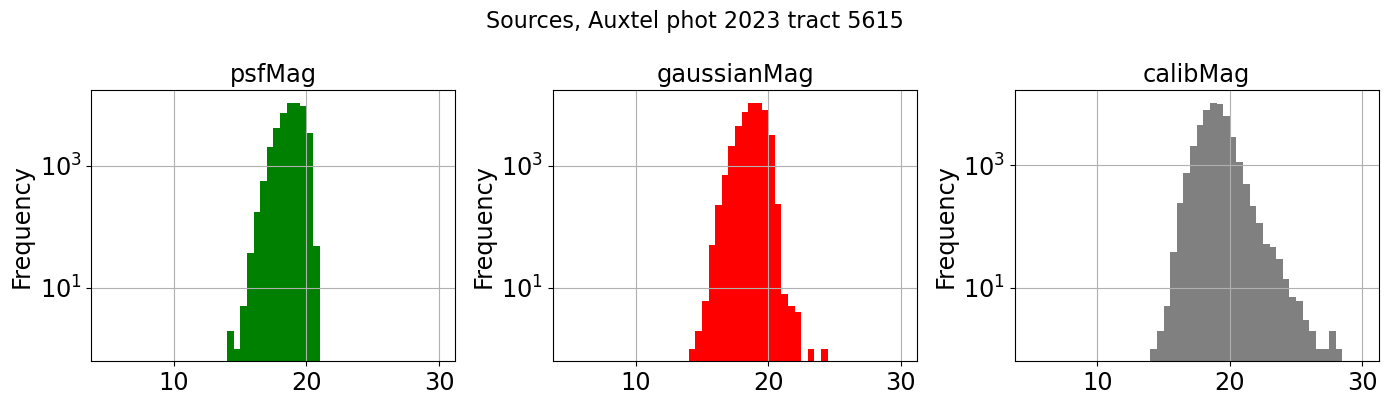

In [32]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))

df['psfMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="g",logy=True,grid=True,title="psfMag",ax=ax1)
df['gaussianMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="r",logy=True,grid=True,title="gaussianMag",ax=ax2)
df['calibMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="grey",logy=True,grid=True,title="calibMag",ax=ax3)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()


In [33]:
selection3  = df["psfMag"] < 20.
df = df[selection3]

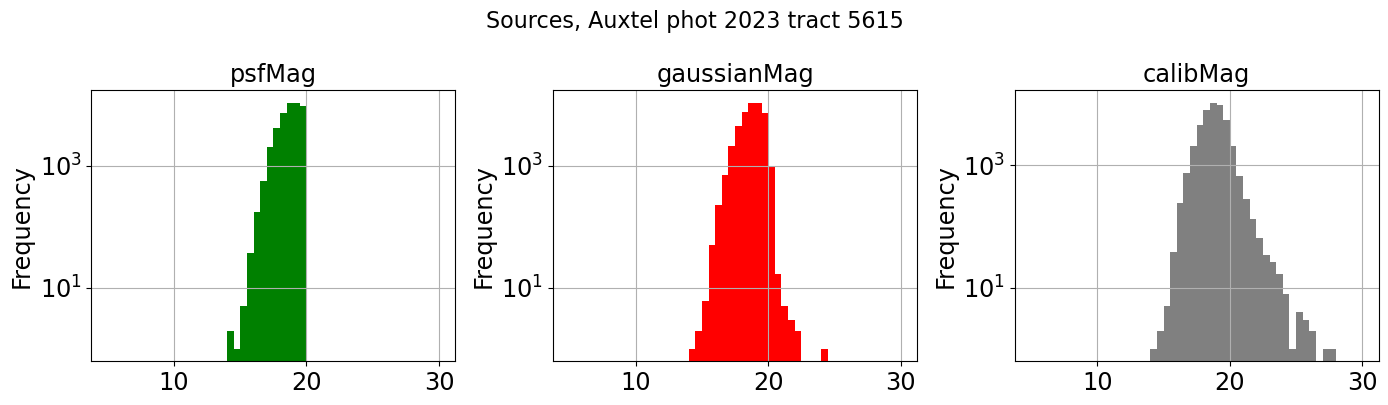

In [34]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))
df['psfMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="g",logy=True,grid=True,title="psfMag",ax=ax1)
df['gaussianMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="r",logy=True,grid=True,title="gaussianMag",ax=ax2)
df['calibMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="grey",logy=True,grid=True,title="calibMag",ax=ax3)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

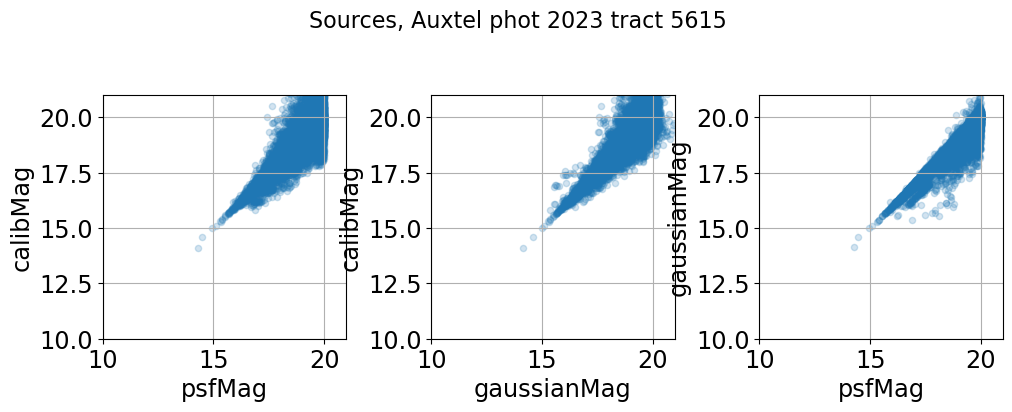

In [35]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,4))
df.plot.scatter(x='psfMag',y='calibMag',marker="o",alpha=0.2,ax=ax1,grid=True)
ax1.set_xlim(10.,21.)
ax1.set_ylim(10.,21.)
ax1.set_aspect('equal')

df.plot.scatter(x='gaussianMag',y='calibMag',marker="o",alpha=0.2,ax=ax2,grid=True)
ax2.set_xlim(10.,21.)
ax2.set_ylim(10.,21.)
ax2.set_aspect('equal')

df.plot.scatter(x='psfMag',y='gaussianMag',marker="o",alpha=0.2,ax=ax3,grid=True)
ax3.set_xlim(10.,21.)
ax3.set_ylim(10.,21.)
ax3.set_aspect('equal')

plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

## Convert dateobs into datetime

In [36]:
df["dateobs"]

sourceId
171629665549549578    2023-05-12 01:37:02.437
171629665549549579    2023-05-12 01:37:02.437
171629665549549580    2023-05-12 01:37:02.437
171629665549549581    2023-05-12 01:37:02.437
171629665549549583    2023-05-12 01:37:02.437
                               ...           
173564928421003395    2023-07-06 05:09:56.474
173564928421003396    2023-07-06 05:09:56.474
173564928421003402    2023-07-06 05:09:56.474
173564928421003513    2023-07-06 05:09:56.474
173564928421003515    2023-07-06 05:09:56.474
Name: dateobs, Length: 45065, dtype: object

In [37]:
df["Time"] = pd.to_datetime(df['dateobs'])

In [38]:
df.Time

sourceId
171629665549549578   2023-05-12 01:37:02.437
171629665549549579   2023-05-12 01:37:02.437
171629665549549580   2023-05-12 01:37:02.437
171629665549549581   2023-05-12 01:37:02.437
171629665549549583   2023-05-12 01:37:02.437
                               ...          
173564928421003395   2023-07-06 05:09:56.474
173564928421003396   2023-07-06 05:09:56.474
173564928421003402   2023-07-06 05:09:56.474
173564928421003513   2023-07-06 05:09:56.474
173564928421003515   2023-07-06 05:09:56.474
Name: Time, Length: 45065, dtype: datetime64[ns]

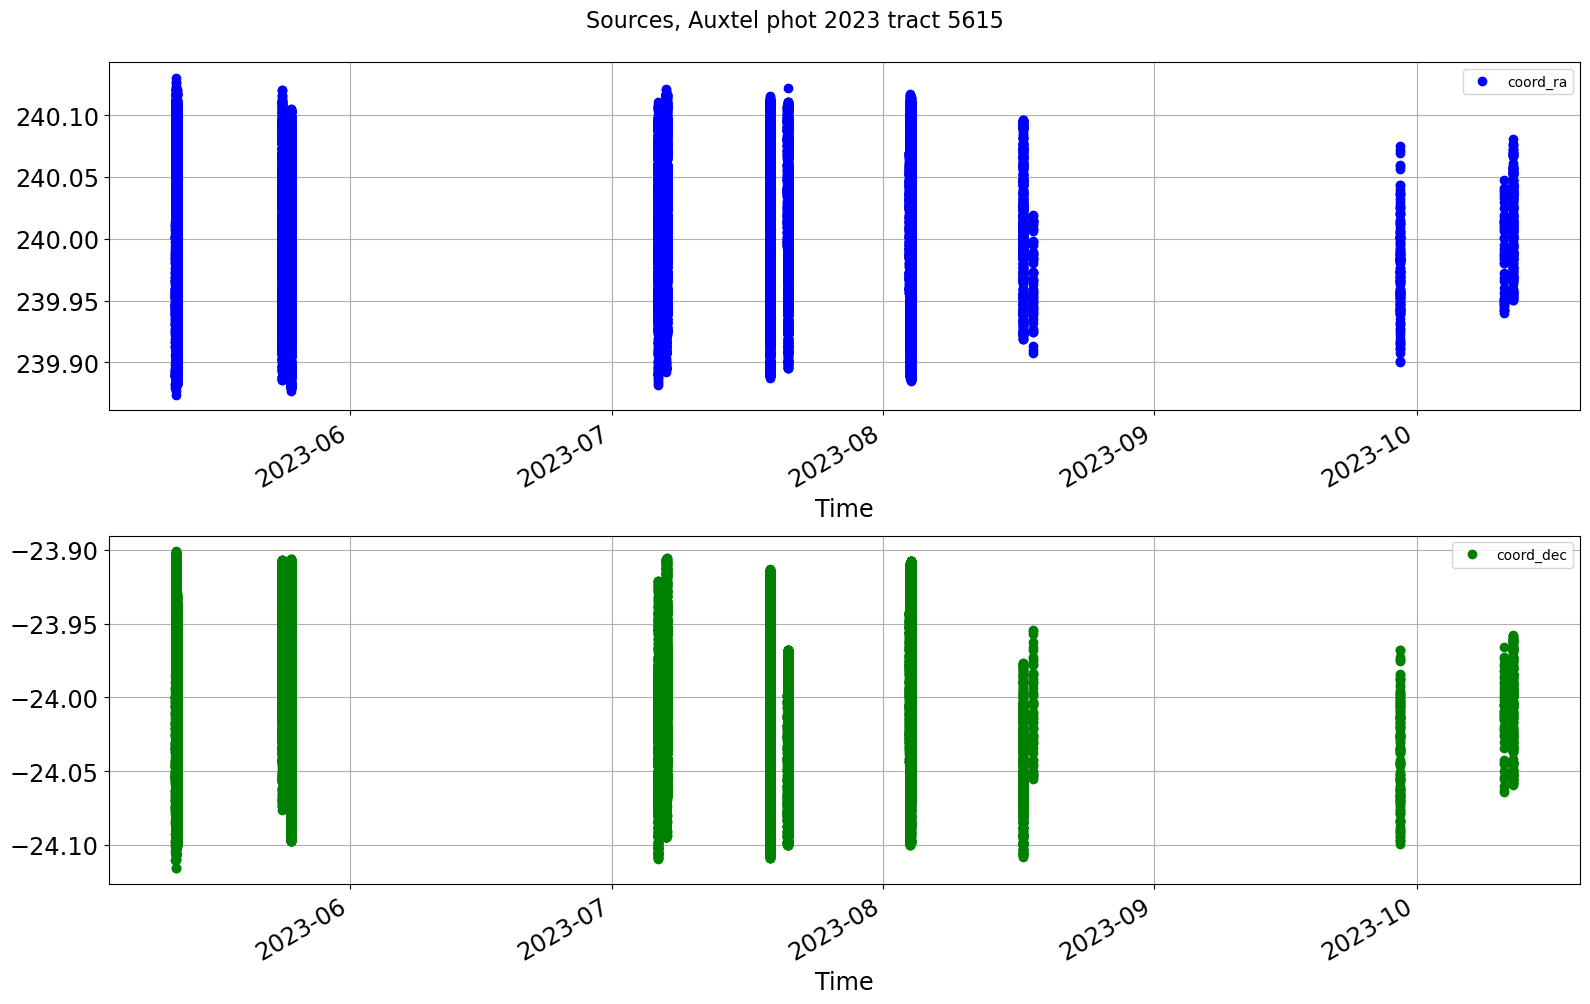

In [39]:
fig,(ax1,ax2) = plt.subplots(2,1)
df.plot(x="Time",y="coord_ra",marker='o',c="b",lw=0.0,ax=ax1,grid=True)
df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

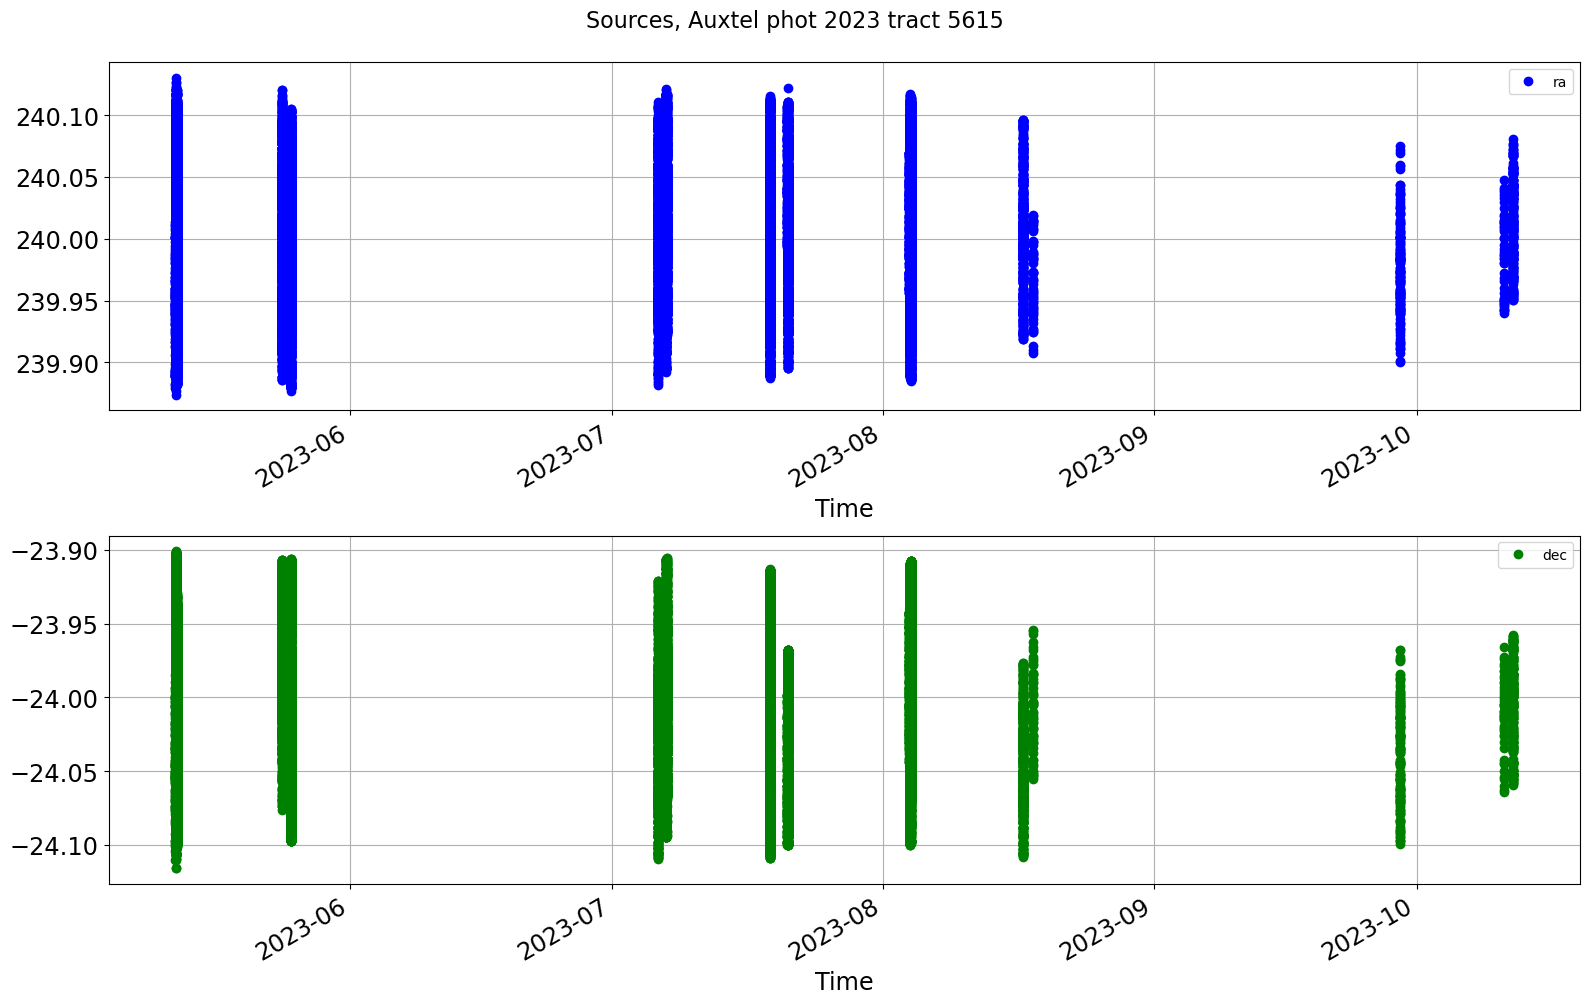

In [40]:
fig,(ax1,ax2) = plt.subplots(2,1)
df.plot(x="Time",y="ra",marker='o',c="b",lw=0.0,ax=ax1,grid=True)
df.plot(x="Time",y="dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

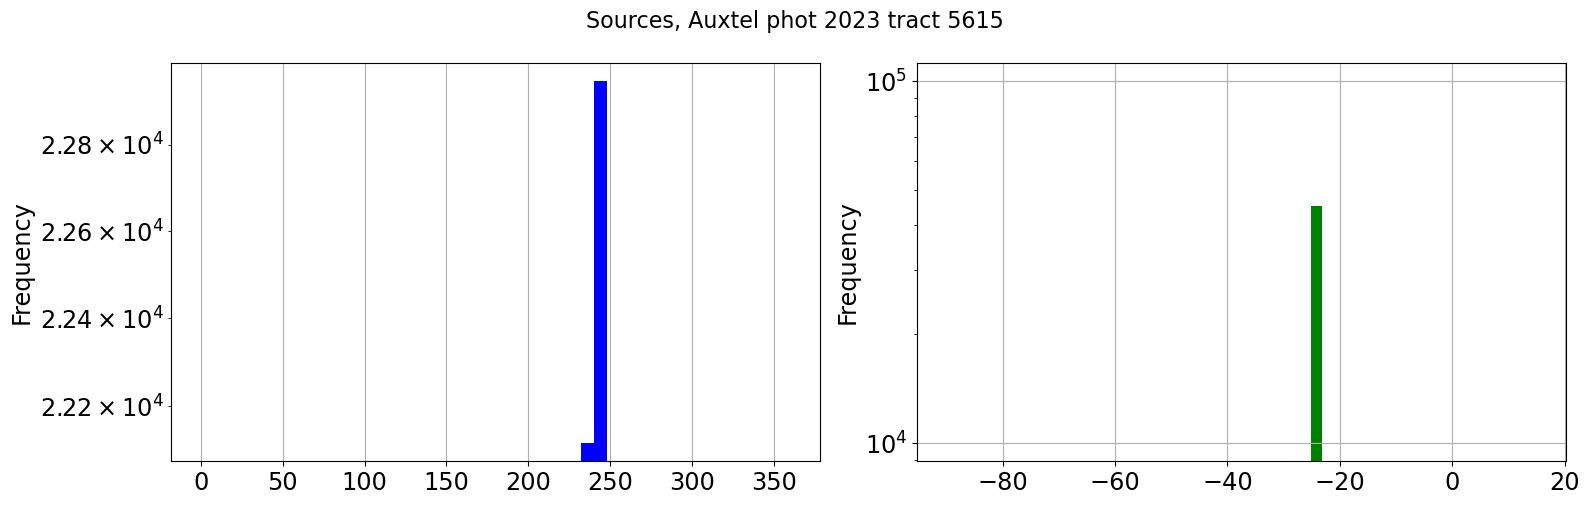

In [41]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
df_sel = df["coord_ra"]
df_sel.plot(kind="hist",x="coord_ra",bins=45,range=(0,360),facecolor="b",ax=ax1,grid=True,logy=True)
df_sel = df["coord_dec"]
df_sel.plot(kind="hist",x="coord_dec",bins=55,range=(-90,15),facecolor="g",ax=ax2,grid=True,logy=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

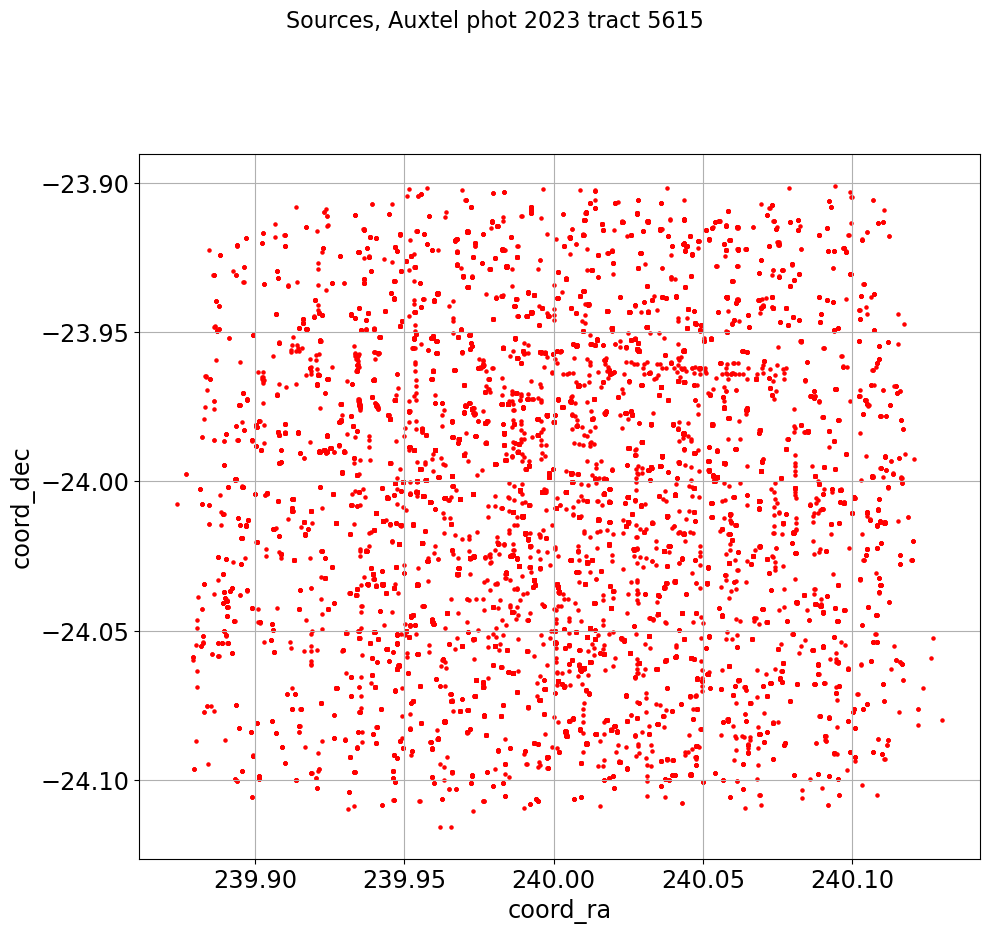

In [42]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
cut1 = (df["ra"]> 200.) &  (df["ra"]<300.)
cut2 = (df["dec"]> -30) &  (df["dec"]<-10)
df_sel = df[cut1 & cut2]
df_sel = df_sel[["coord_ra","coord_dec"]]
df_sel.plot(kind="scatter",x="coord_ra",y="coord_dec",marker=".",c="r",ax=ax,grid=True)
plt.gca().set_aspect('equal')
plt.suptitle(suptitle,fontsize=16)
plt.tight_layout()

## Sky map

In [43]:
ra = coord.Angle(df["coord_ra"].values, unit=u.degree)
dec = coord.Angle(df["coord_dec"].values, unit=u.degree)
#
ra  = ra.wrap_at(180*u.degree).radian
dec = dec.radian
#
df["RA"] = ra
df["DEC"] = dec

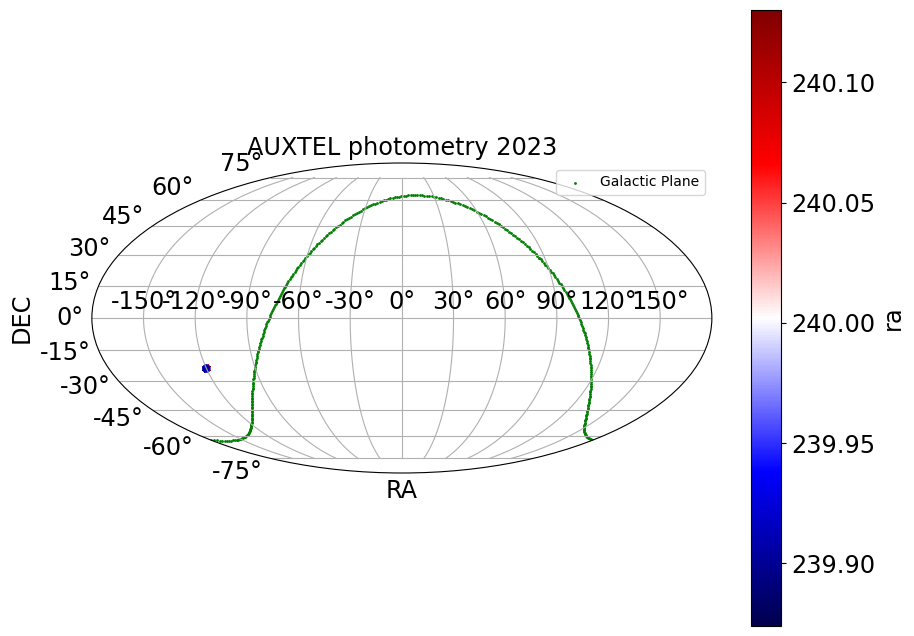

In [44]:
fig = plt.figure()
#ax = fig.add_subplot(111, projection="aitoff")
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(gp_ra_toplot.radian, gp_radec.dec.radian,c="g",label="Galactic Plane",s=1)
df.plot.scatter(x='RA',y='DEC',c='ra',colormap='seismic',grid=True,ax=ax,figsize=(10,8),title='AUXTEL photometry 2023')
ax.legend()

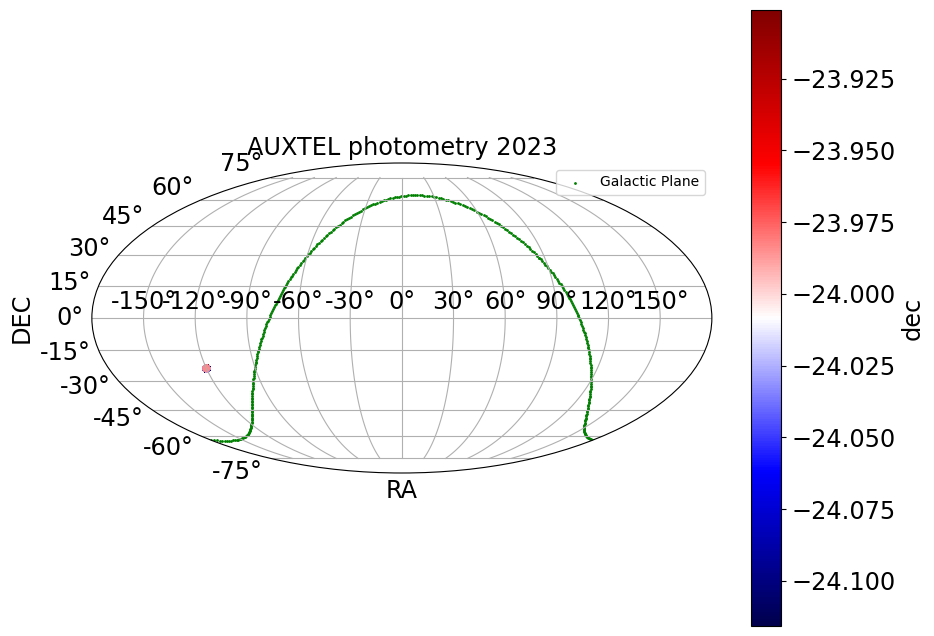

In [45]:
fig = plt.figure()
#ax = fig.add_subplot(111, projection="aitoff")
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(gp_ra_toplot.radian, gp_radec.dec.radian,c="g",label="Galactic Plane",s=1)
df.plot.scatter(x='RA',y='DEC',c='dec',colormap='seismic',grid=True,ax=ax,figsize=(10,8),title='AUXTEL photometry 2023')
ax.legend()

In [46]:
df["RAdeg"] = df["RA"]*180/np.pi
df["DECdeg"] = df["DEC"]*180/np.pi

Text(0.5, 1.0, 'Sources, Auxtel phot 2023 tract 5615')

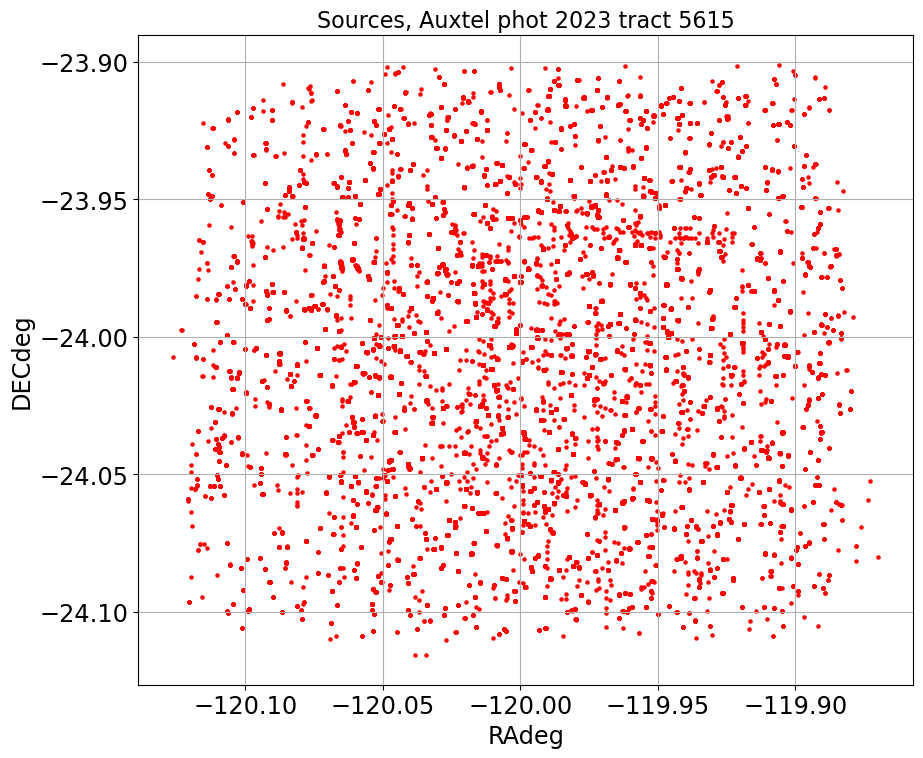

In [47]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
cut1 = (df["ra"]> 200.) &  (df["ra"]<300.)
cut2 = (df["dec"]> -30) &  (df["dec"]<-10)
df_sel = df[cut1 & cut2]
df_sel = df_sel[["RAdeg","DECdeg"]]
df_sel.plot(kind="scatter",x="RAdeg",y="DECdeg",marker=".",c="r",ax=ax,grid=True)
plt.gca().set_aspect('equal')
plt.title(suptitle,fontsize=16)

Text(0.5, 1.0, 'Sources, Auxtel phot 2023 tract 5615')

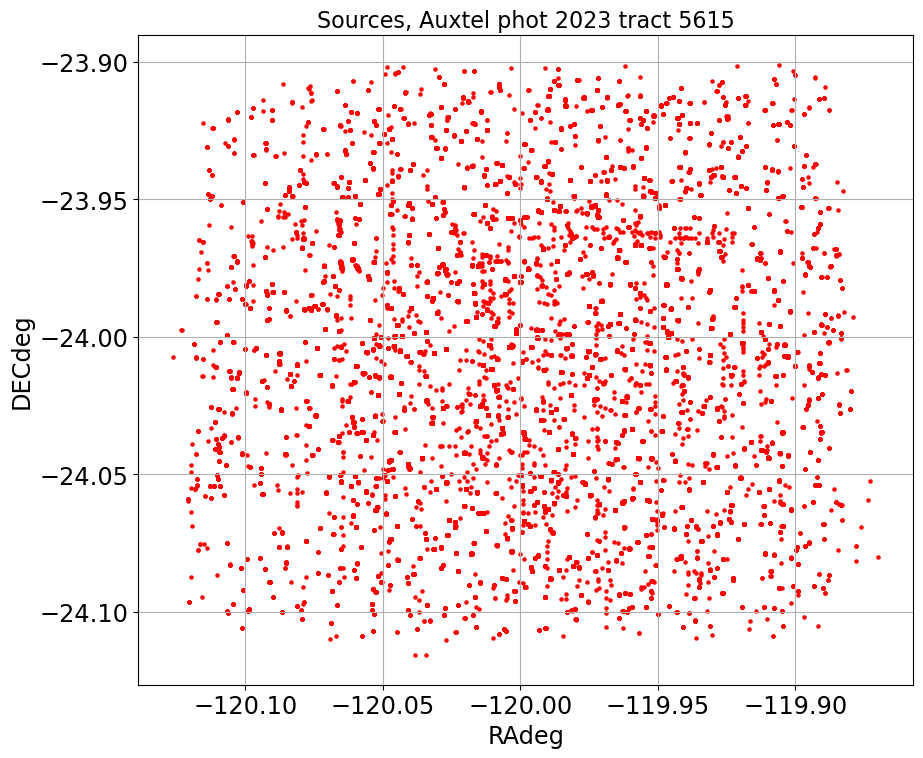

In [48]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
cut1 = (df["RAdeg"]> -130.) &  (df["RAdeg"]<-115.)
cut2 = (df["dec"]> -30) &  (df["dec"]<-10)
df_sel = df[cut1 & cut2]
df_sel = df_sel[["RAdeg","DECdeg"]]
df_sel.plot(kind="scatter",x="RAdeg",y="DECdeg",marker=".",c="r",ax=ax,grid=True)
plt.gca().set_aspect('equal')
plt.title(suptitle,fontsize=16)

Text(0.5, 1.0, 'Sources, Auxtel phot 2023 tract 5615')

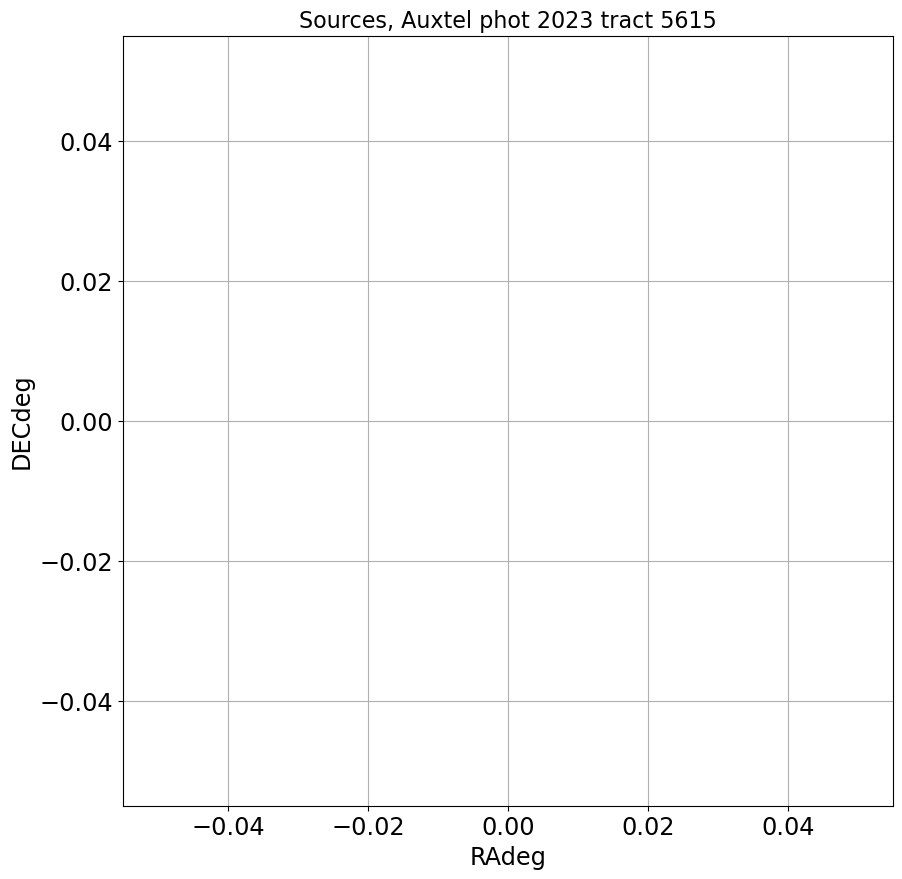

In [49]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
cut1 = (df["RAdeg"]> -95.) &  (df["RAdeg"]<-80.)
cut2 = (df["dec"]> -30) &  (df["dec"]<-10)
df_sel = df[cut1 & cut2]
df_sel = df_sel[["RAdeg","DECdeg"]]
df_sel.plot(kind="scatter",x="RAdeg",y="DECdeg",marker=".",c="r",ax=ax,grid=True)
plt.gca().set_aspect('equal')
plt.title(suptitle,fontsize=16)